# Direct Wish et al., 1976 Replication
## 25 relationships, rated on 25 dimensions (bipolar scales)

In [1]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
from sklearn import manifold, preprocessing
from sklearn.metrics import euclidean_distances
from sklearn.decomposition import PCA

## Import qualtrics data and create dataframes for the raw data, raw data with reorganized headers, and a dataframe for just the responses

In [2]:
work_dir = os.path.expanduser('~/Google_Drive/olson_lab/projects/relationship_knowledge/surveys/wish_replication/')
os.chdir(work_dir)

# Grab the qualtrics output
qual_output = [i for i in os.listdir('./') if i.startswith('RK')][0]

# Prep responses and key
raw = pd.read_csv(qual_output)
raw_reorg = raw.drop(axis='index',index=[0,1])
raw_reorg['subject'] = list(raw_reorg.index)
raw_reorg = raw_reorg.reset_index(drop=True)
raw_reorg['Duration (in seconds)'] = pd.to_numeric(raw_reorg['Duration (in seconds)'])
key = pd.read_csv('qualtrics_question_key.csv')

responses = raw_reorg
responses['subject'] = list(raw_reorg.index)
responses = responses.loc[:, responses.columns.str.startswith('Q')]
responses = responses[responses.columns[1:-7]]
#responses = responses.apply(pd.to_numeric)

# Get total number of responses
print("Total number of responses from qualtrics - "+str(len(responses)))

Total number of responses from qualtrics - 721


count      699
unique       3
top       Male
freq       349
Name: Sex, dtype: object

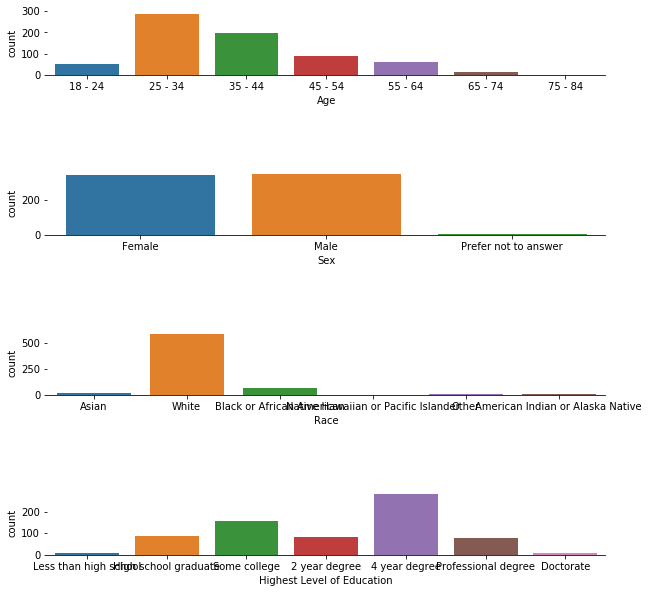

In [3]:
# Demographics
demo_orig = pd.read_csv(qual_output, header=1, 
                           usecols=range(len(raw_reorg.iloc[0])-9,
                                         len(raw_reorg.iloc[0])-1))
demo_orig = demo_orig.drop(axis='index',index=0)
demographics = demo_orig
#demographics = demographics.drop(axis='index',index=0)


# Plot demographic information
# Set up the matplotlib figure
#sns.set(font_scale=1.2)
#sns.set_style("whitegrid")
f, axes = plt.subplots(4, 1, figsize=(10, 10), sharex=False)
f.subplots_adjust(wspace = 10, hspace=1.5)
sns.despine(left=True)
sns.countplot(demographics['Age'], ax=axes[0], order=['18 - 24', '25 - 34',
                                                      '35 - 44', '45 - 54',
                                                      '55 - 64', '65 - 74',
                                                      '75 - 84'])
sns.countplot(demographics['Sex'], ax=axes[1])
sns.countplot(demographics['Race'], ax=axes[2])
sns.countplot(demographics['Highest Level of Education'], ax=axes[3],
              order=['Less than high school', 'High school graduate',
                     'Some college', '2 year degree', '4 year degree',
                     'Professional degree','Doctorate'])

demographics['Sex'].describe(include="all")



***
### Create a dictionary that will store dataframes for each dimensions
### Dataframes have ratings all relationships

In [4]:
relationships = [x for x in raw.iloc[0].tolist() if x.startswith('Q8.1')]
relationships = [s.replace('\xe2\x80\x93', '-') for s in relationships]
relationships = [x[7:] for x in relationships]
dimension_frames = {}
count=0
for dim in key['dimension'].tolist()[:-2]:  # exclude foil and demographics
    filtered_cols = [col for col in raw_reorg if col.startswith('Q'+str(key['block'].iloc[count])+'.1')]
    dimension_frames[dim] = pd.DataFrame(responses[filtered_cols])
    dimension_frames[dim].columns = relationships
    # Delete all data for "between cousins" and only keep "second cousins"
    dimension_frames[dim]['Between second cousins'].iloc[:629] = np.nan
    count=count+1


### Check total number of responses for each word before and after removing bad participants
Foil questions were used to catch participants who were not paying attention or taking the survey seriously

Total number of responses, excluding bad participants - 592


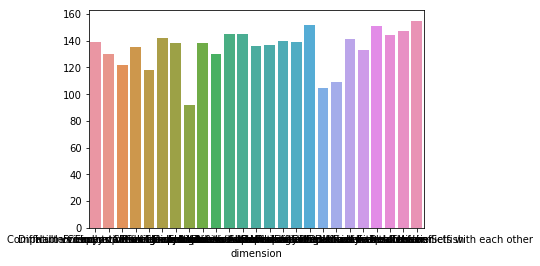

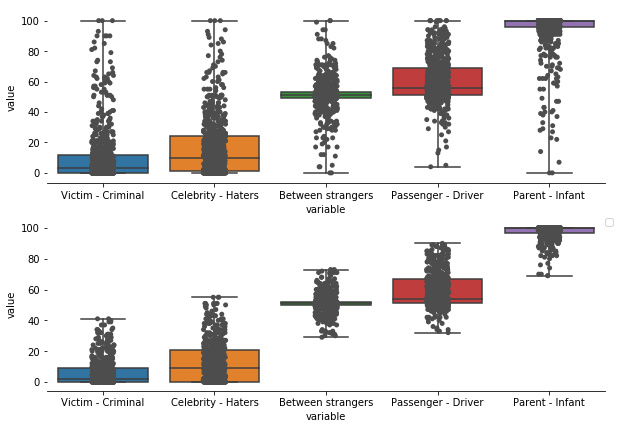

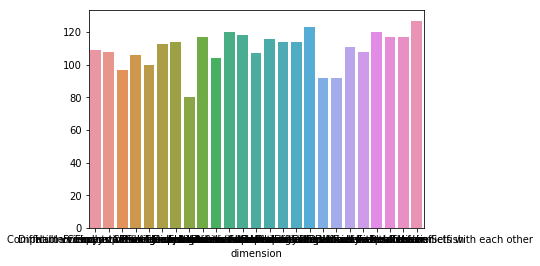

In [5]:
num_response = []
for col in dimension_frames['Active vs Inactive'].columns:
    num_response.append(dimension_frames['Active vs Inactive'][col].count())
plt.figure()
sns.barplot(x=key['dimension'].iloc[:25],y=num_response)


# Check foils to see if any subjs responded indiscriminately
foil_relationships = [x for x in raw.iloc[0].tolist() if x.startswith('Q37')]
foil_relationships = [x[6:] for x in foil_relationships]
filtered_cols = [col for col in raw_reorg if col.startswith('Q37')]
foils = pd.DataFrame(responses[filtered_cols])
foils.columns = foil_relationships
foils['MTurkCode']  =raw_reorg['MTurkCode']
foils = foils.apply(pd.to_numeric)
foils_melt = pd.melt(foils, id_vars='MTurkCode')

# Check for values above means for unexpected foils
outliers_list = []
for rel in foils.columns[:-1]:
    outliers_list = outliers_list + list(foils[(foils[rel] > 
                   foils[rel].mean()+foils[rel].std()*2) |
                   (foils[rel] < 
                    foils[rel].mean()-foils[rel].std()*2)].index)
outliers_list = set(outliers_list)



# Remove outliers based on assumptions of words
# Frequency of deathbed > car
# Removing subjects based on completetion time is not the best (they do okay)
foil_outliers = foils
foil_outliers = foil_outliers[~foil_outliers.index.isin(outliers_list)]
foil_outliers_melt = pd.melt(foil_outliers, id_vars='MTurkCode')

#foil_outliers = foils[~foils.index.isin(outliers_list)]

f, axes = plt.subplots(2, 1, figsize=(10, 7), sharex=False)
sns.despine(left=True)
sns.stripplot(x="variable", y="value", data=foils_melt, 
              color='.3', jitter=True, ax=axes[0])
#axes[0].legend_.remove()
sns.stripplot(x="variable", y="value", data=foil_outliers_melt, 
              color='.3', jitter=True,  ax=axes[1])
sns.boxplot(x="variable", y="value", data=foils_melt, whis=np.inf, ax=axes[0])
sns.boxplot(x="variable", y="value", data=foil_outliers_melt, whis=np.inf, ax=axes[1])
plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.0)


# Remove outliers from the rest of the data
dimension_frames_outliers = dimension_frames.copy()
for dim in dimension_frames_outliers:
    dimension_frames_outliers[dim] = dimension_frames[dim][~dimension_frames[dim].index.isin(outliers_list)]
    dimension_frames_outliers[dim] = dimension_frames_outliers[dim].apply(pd.to_numeric)
    
    
# Check total number of responses for each word with outliers excluded
num_response = []
for col in dimension_frames_outliers['Active vs Inactive'].columns:
    num_response.append(dimension_frames_outliers['Active vs Inactive'][col].count())
plt.figure()
sns.barplot(x=key['dimension'].iloc[:25],y=num_response)

print("Total number of responses, excluding bad participants - "+str(len(dimension_frames_outliers['Active vs Inactive'])))


***
## Principal Component Analysis

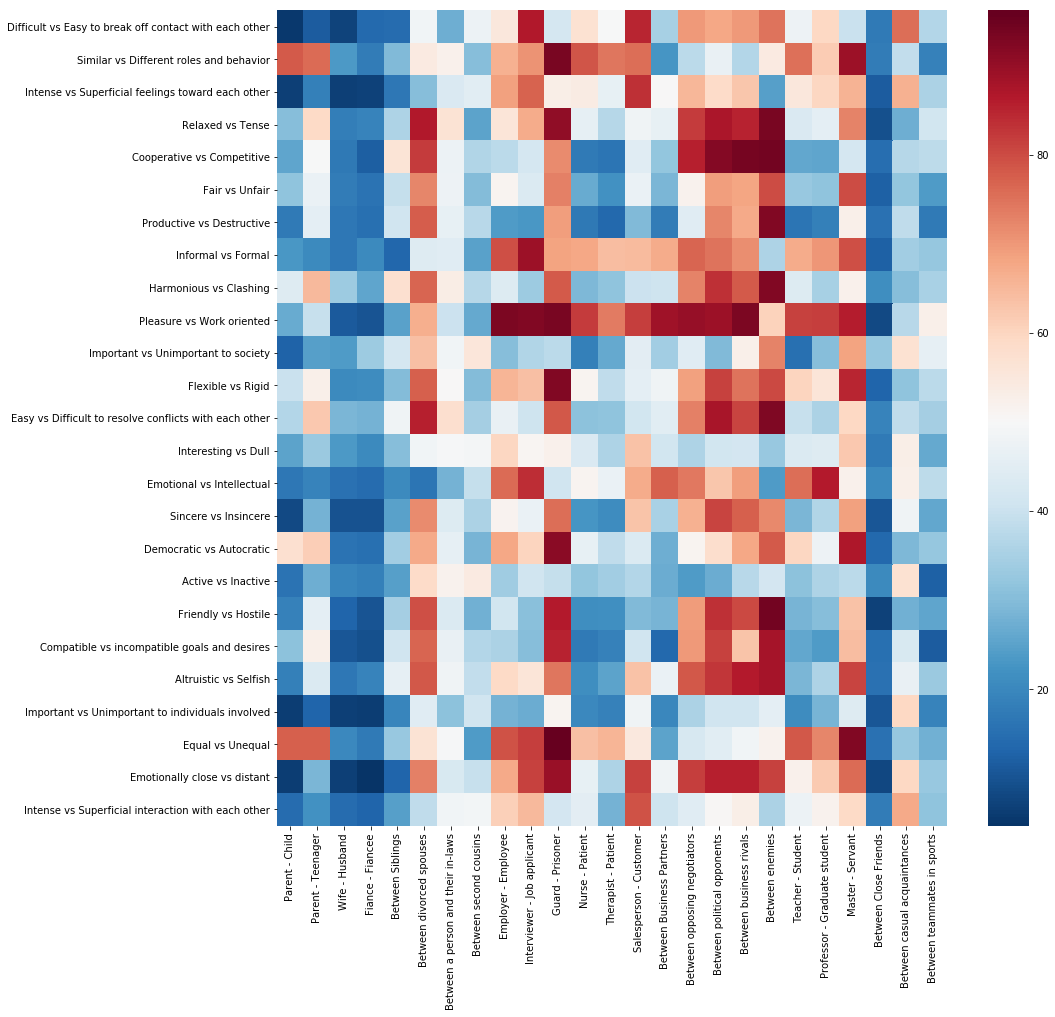

In [6]:
# Create a dataframe that has the average response for each relationship, on each dimension
dim_rel = pd.DataFrame(columns=relationships)
count=0
for dim in dimension_frames_outliers.keys():
    dim_rel.loc[count] = dimension_frames_outliers[dim].mean().tolist()
    count = count + 1
dim_rel.index = dimension_frames_outliers.keys()

#dim_rel.to_csv('results/dim_rel.csv')

dim_rel_2sd = dim_rel

#ax = sns.heatmap(dim_rel)
plt.figure(figsize=(15,15))
heatmap = sns.heatmap(dim_rel, center=50,cmap="RdBu_r")
fig = heatmap.get_figure()

### Explore explained variance and loading scores of components

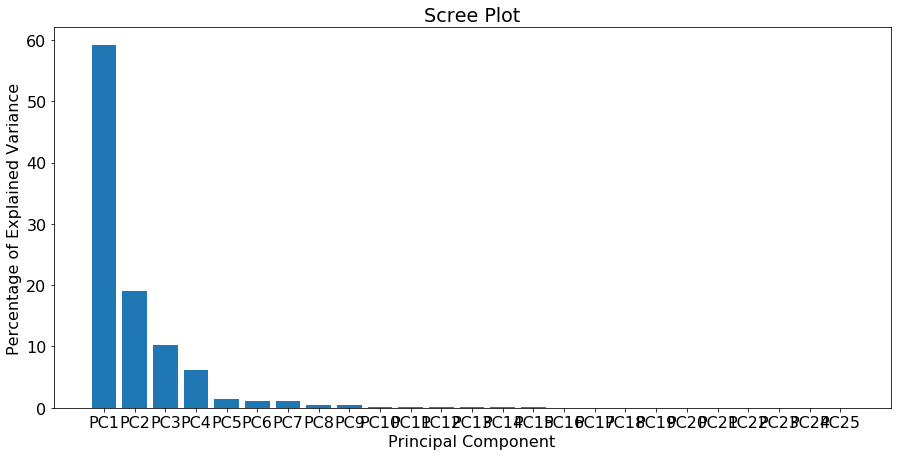

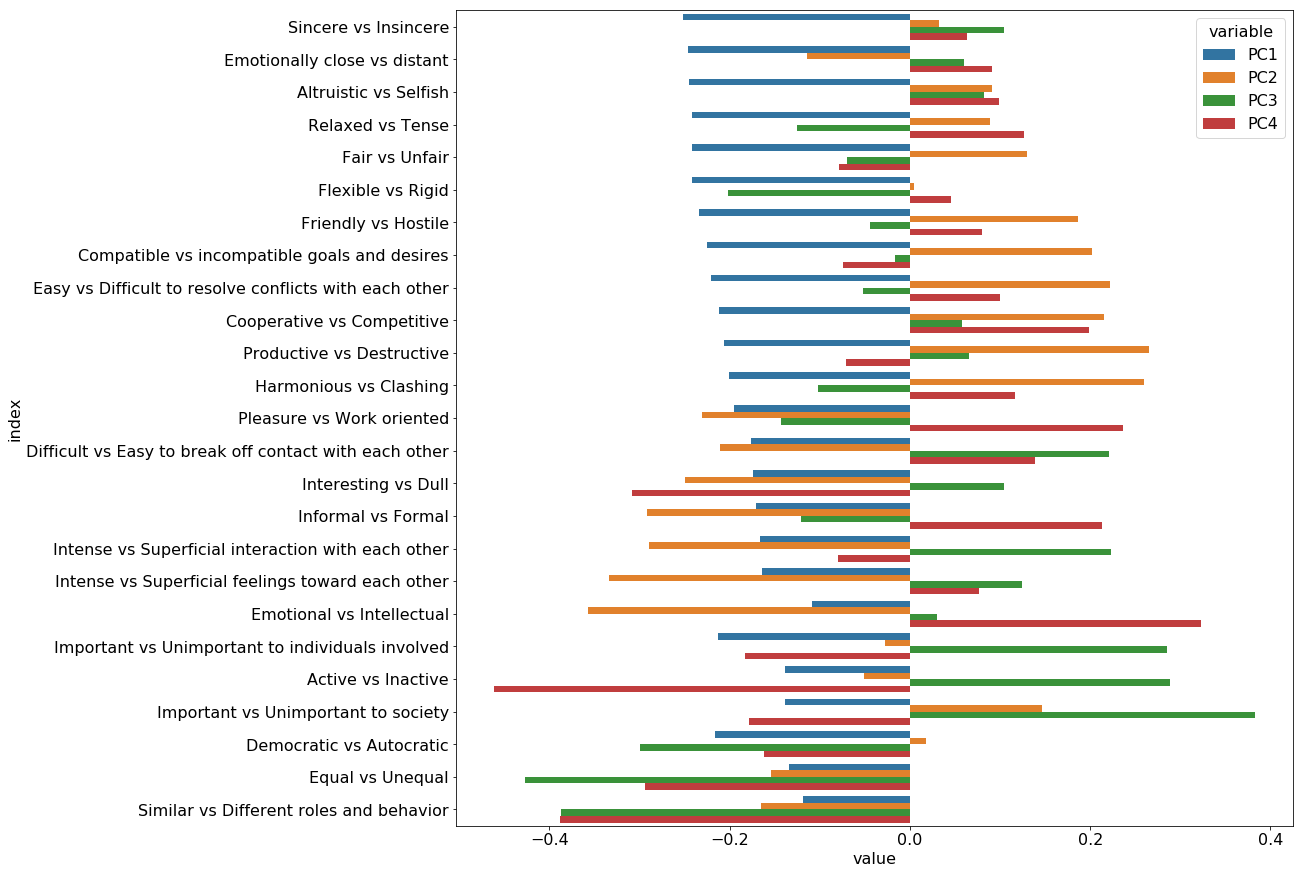

In [9]:
dim_rel_scaled = preprocessing.scale(dim_rel.transpose())

# Create PCA object and fit
#   Do all the PCA math like calculate loading scores and the variation of each component
pca = PCA()
pca.fit(dim_rel_scaled)

# Generate coordinates
pca_data = pca.transform(dim_rel_scaled)

# Scree plot
#   Calculate % of variance that each component accounts for
per_var = np.round(pca.explained_variance_ratio_*100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]
plt.figure(figsize=(15,7))
plt.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=labels)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Component')
plt.title('Scree Plot')
plt.show()


pca_df = pd.DataFrame(pca_data, columns=labels, index=relationships)

# Look at the loading scores
loading_scores = pd.DataFrame(pca.components_.T, columns=pca_df.columns, index=dimension_frames_outliers.keys())
#loading_scores_sorted = loading_scores.abs().sort_values(ascending=False)
loading_scores['Order'] = [25, 11, 14, 9, 2, 8, 5, 18, 1, 17, 16, 24, 6, 15, 
                           19, 23, 20, 12, 3, 4, 7, 21, 10, 22, 13]
loading_scores = loading_scores.sort_values(['Order'])
#loading_scores.to_csv('results/pca_loading_scores.csv')



#reorder = [14,12,7,8,13,9,3,5,4,23,24,21,19,20,17]
loading_scores_reorder = loading_scores
#loading_scores_reorder = loading_scores.sort_values(['PC1','PC2','PC3'])
loading_scores_reorder['Order'] = [11,9,6,7,10,8,2,4,3,23,24,20,16,17,14,21,12,15,18,22,19,1,0,5,13]
loading_scores_reorder = loading_scores.sort_values(['Order'])
#pca_plot_data = pd.melt(loading_scores_reorder[['PC1','PC2','PC3']].reset_index(), id_vars='index')
pca_plot_data = pd.melt(loading_scores_reorder[['PC1','PC2','PC3','PC4']].reset_index(), id_vars='index')

plt.figure(figsize=(15,15))
sns.barplot(x='value', y='index', hue='variable', data=pca_plot_data)


#### Component comparison to Wish's dimensions
The first four components were chosen as the scree plot shows that 1) the "elbow rule" indicates that the first 4 components are ideal, and 2) the first 4 components explain 95% of the variance

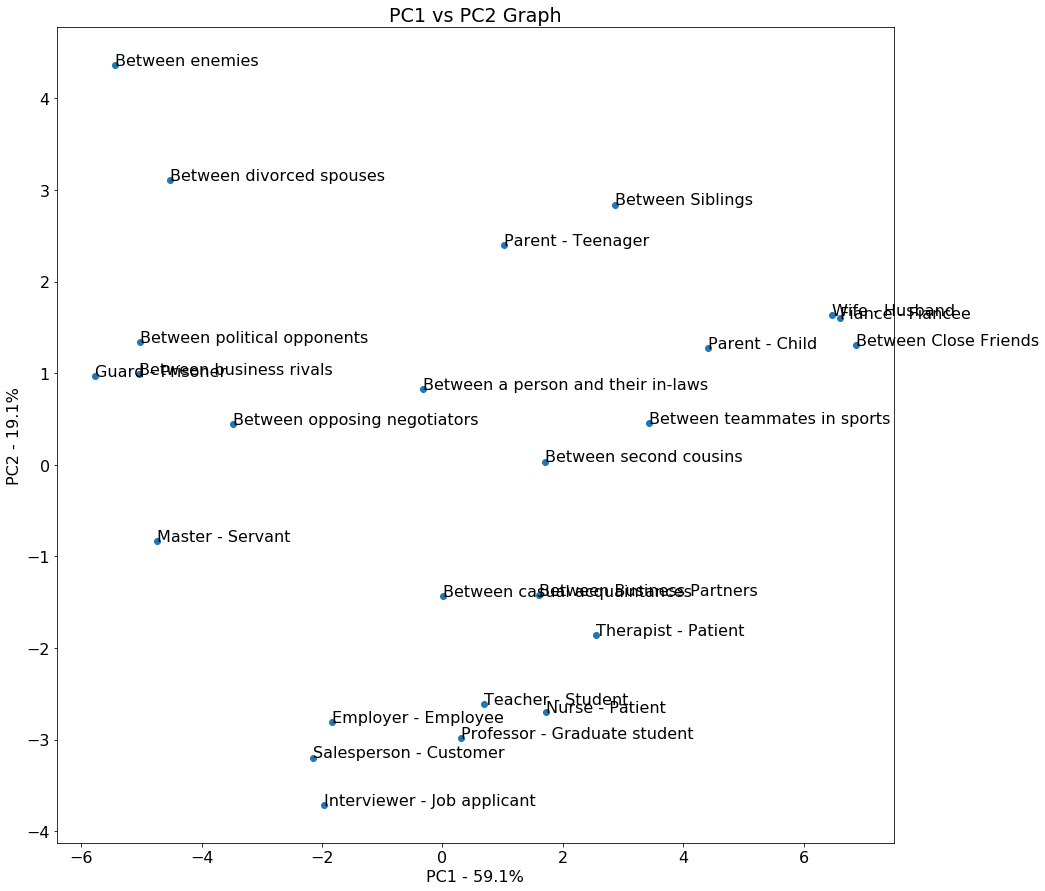

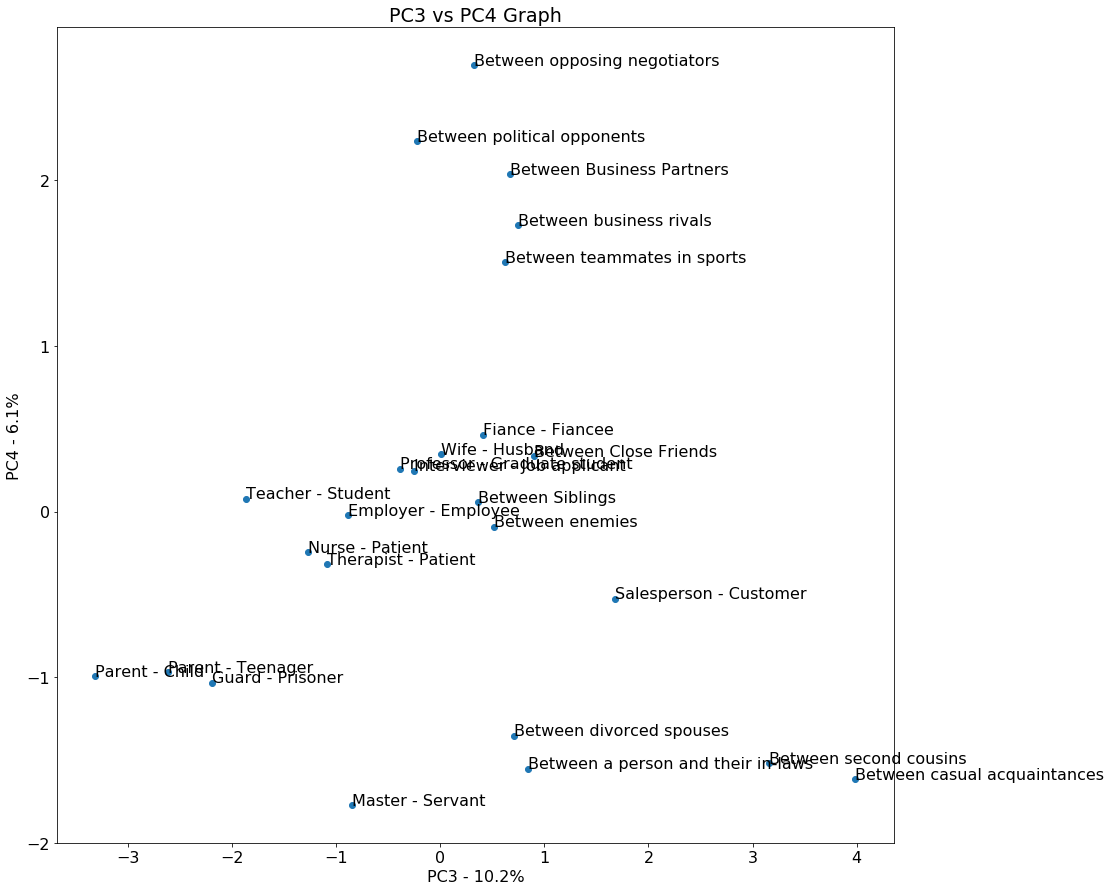

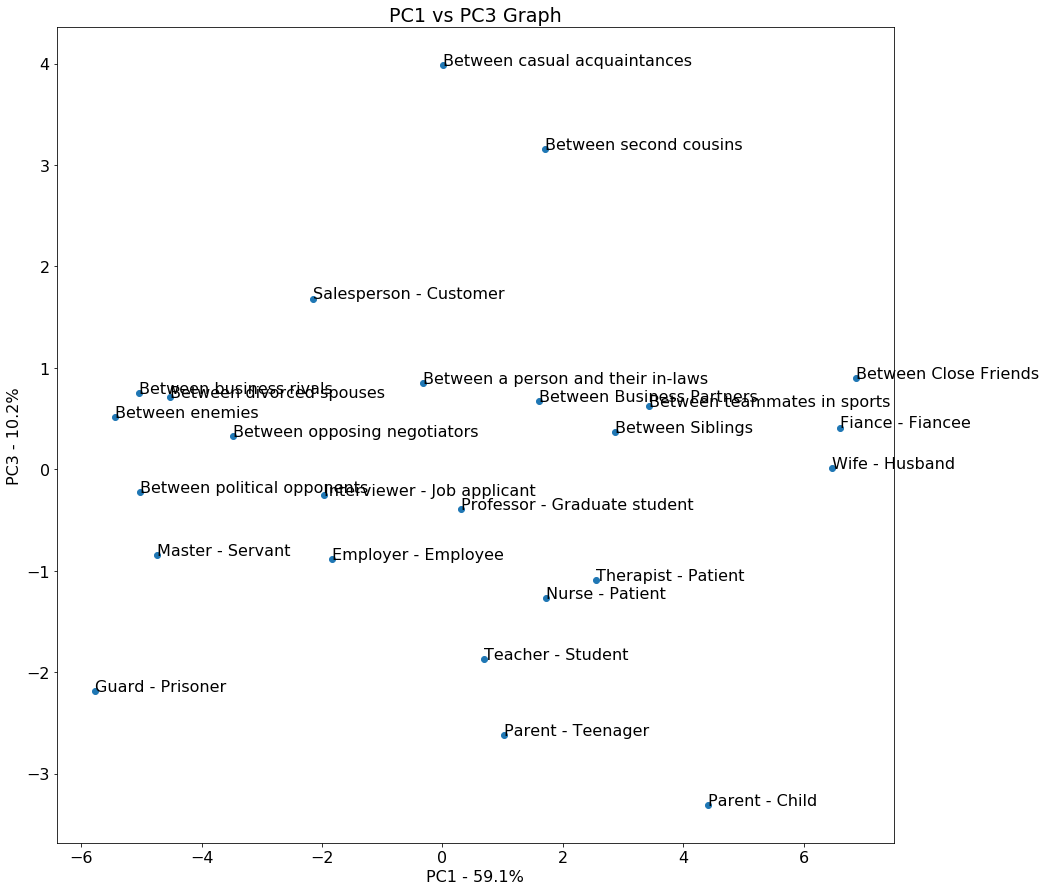

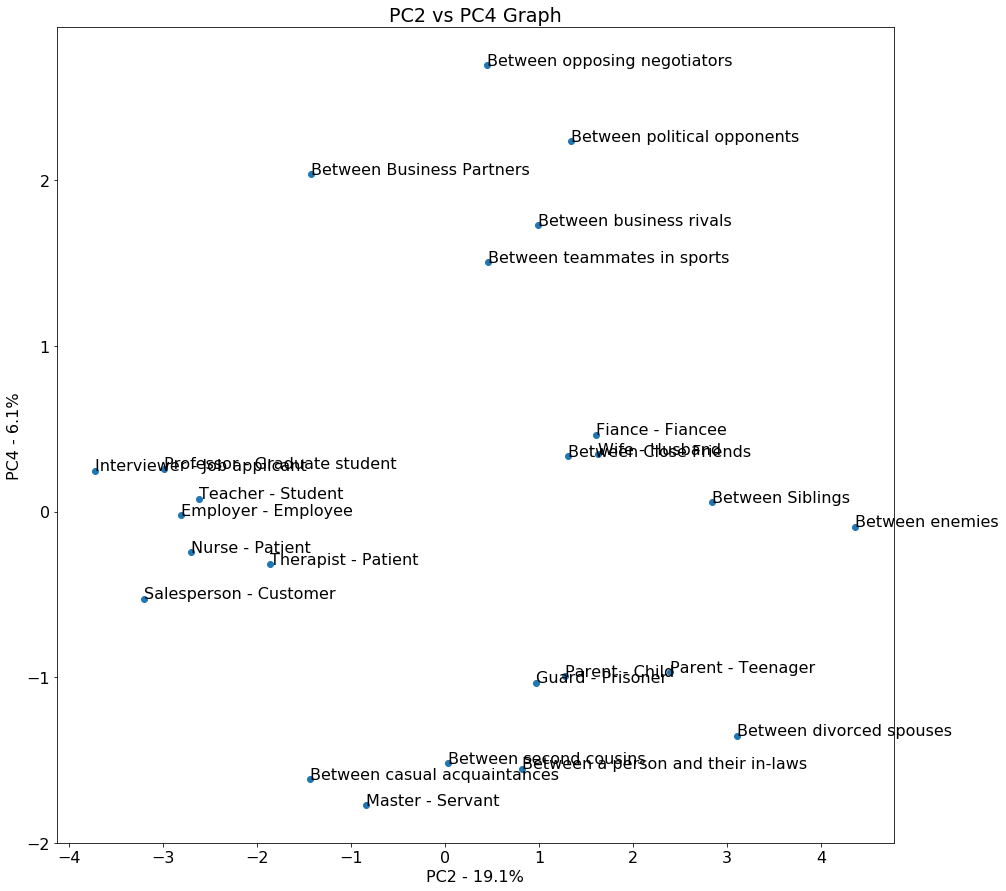

In [10]:
# PCA graph
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(15,15))
plt.scatter(pca_df.PC1, pca_df.PC2)
plt.title('PC1 vs PC2 Graph')
plt.xlabel('PC1 - {0}%'.format(per_var[0]))
plt.ylabel('PC2 - {0}%'.format(per_var[1]))

for sample in pca_df.index:
    plt.annotate(sample, (pca_df.PC1.loc[sample], pca_df.PC2.loc[sample]))

plt.show()


plt.figure(figsize=(15,15))
plt.scatter(pca_df.PC3, pca_df.PC4)
plt.title('PC3 vs PC4 Graph')
plt.xlabel('PC3 - {0}%'.format(per_var[2]))
plt.ylabel('PC4 - {0}%'.format(per_var[3]))

for sample in pca_df.index:
    plt.annotate(sample, (pca_df.PC3.loc[sample], pca_df.PC4.loc[sample]))

plt.show()
#plt.savefig("results/pca_scatter_pc3_pc4.png")

plt.figure(figsize=(15,15))
plt.scatter(pca_df.PC1, pca_df.PC3)
plt.title('PC1 vs PC3 Graph')
plt.xlabel('PC1 - {0}%'.format(per_var[0]))
plt.ylabel('PC3 - {0}%'.format(per_var[2]))

for sample in pca_df.index:
    plt.annotate(sample, (pca_df.PC1.loc[sample], pca_df.PC3.loc[sample]))

plt.show()
#plt.savefig("results/pca_scatter_pc1_pc3.png")

plt.figure(figsize=(15,15))
plt.scatter(pca_df.PC2, pca_df.PC4)
plt.title('PC2 vs PC4 Graph')
plt.xlabel('PC2 - {0}%'.format(per_var[1]))
plt.ylabel('PC4 - {0}%'.format(per_var[3]))

for sample in pca_df.index:
    plt.annotate(sample, (pca_df.PC2.loc[sample], pca_df.PC4.loc[sample]))

plt.show()

3 out of 4 of Wish et al., 1976 dimensions were replicated. These dimensions (called components in this analysis) are:

PC1 - Relational valence (called competitive & hostile vs cooperative & friendly in Wish et al., 1976)

PC2 - Emotional intensity (called casual vs intense in Wish et al., 1976)

PC3 - Equality (called equal vs unequal in Wish et al., 1976)

Wish's 4th dimension (socioemotional & informal vs task-oriented & formal) was not replicated and we were unable to pinpoint the main theme of PC4. Maybe it is a form of formality.

